# 05.9 Ejercicio de entrenamiento de una red usando la infraestructura ResNet-50 que incorpora convoluciones (Información Complementaria)

Se presenta un ejercicio para ver como volcar los datos de imagenes sobre la red de convolución ResNet-50 y hacer una entrenamiento. Es una mera prueba de concepto por no disponerse de suficientes ejemplos para hacer un entrenamiento adecuado.

Se observará un __sobreajuste en el conjunto de entrenamiento__, mientras que en el conjunto de pruebas no se obtiene una buena exactitud.

__El resultado es lógico por usar un conjunto de datos en número insuficiente__

ResNet-50

https://pytorch.org/hub/pytorch_vision_resnet/

https://www.aprendemachinelearning.com/como-funcionan-las-convolutional-neural-networks-vision-por-ordenador/

Cursillo
https://atcold.github.io/pytorch-Deep-Learning/es/week01/01-1/

En el problema de __MNIST__, las imágenes son de 28x28; por lo que una sola neurona plenamente conectado en una primera capa oculta de una red neuronal ordinaria tendría 28 x 28 = 784 pesos. Esta cantidad todavía parece manejable, pero es evidente que esta estructura totalmente conectado no funciona bien con imágenes más grandes. 

__Las redes neuronales convolucionales__ modelan de forma consecutiva pequeñas piezas de información, combinando esta información en las capas más profundas de la red. La primera capa intentará detectar los __bordes__ y establecer patrones de detección de bordes. Luego, las capas posteriores trataran de combinarlos en formas más simples y, finalmente, en patrones de las diferentes posiciones de los objetos, __iluminación__, __escalas__, etc. Las capas finales intentarán hacer coincidir una imagen de entrada con todas los patrones y llegar a una predicción final como una suma ponderada de todos ellos, usando ya una red densa.

Las __redes neuronales constan de 3 tipos__ de capas:

1. __Convolucional__, que es la que le da le nombre a la red.
2. De reducción o de __pooling__, la cual va a reducir la cantidad de parámetros al quedarse con las características más comunes.
3. __Clasificadora__, capa densa totalmente conectada, que da el resultado final de la red.

La __imagen de entrada__ puede ser una matriz $n \times m$ de enteros que representan el nivel de gris o una triple matriz de enteros representando los canales rojo, verde y azul en el caso de imagen de color. La matriz dará lugar a $n \times m$ neuronas de entradas, simple o triple.

La __operación de convolución__ se aplica sobre la imagen de entrada recibe como entrada o input la imagen y luego aplica sobre ella un filtro o kernel que nos devuelve un mapa de las características de la imagen original.

La __capa de reducción o pooling__ se coloca generalmente después de la capa convolucional. Reduce las dimensiones espaciales (ancho x alto) del volumen de entrada para la siguiente capa convolucional. No afecta a la dimensión de profundidad del volumen. La operación que se suele utilizar en esta capa es __max-pooling__, que divide a la imagen de entrada en un conjunto de rectángulos y, respecto de cada subregión, se va quedando con el máximo valor.

Al final de las capas convolucional y de pooling, la __capa clasificadora__ serán capas completamente conectadas en la que cada pixel se considera como una neurona separada. Y en salida habrá tantas neuronas como clases se deban predecir. 

In [1]:
import glob, os
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import torch
import torch.nn as nn

C:\Users\valer_z\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\valer_z\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
labels_animals = ["perro", "gato", "caballo", "vaca"]

In [3]:
def getLabelFileName(fileName):
  for k in range(np.size(labels_animals)):
    if (fileName.find(labels_animals[k])>-1):
      return k
  return -1

In [4]:
def importImagesFromPath(my_directory):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    #print(my_directory)
    #os.chdir(my_directory)
    imag_animal, label_animal =  [],[]
    #print(my_directory+"*.jpg")
    for file in glob.glob(my_directory+"/*.jpg"):
        #print(file)
        label_animal.append(getLabelFileName(file))
        PILimag = Image.open(file)
        TensorImag = transform(PILimag)
        BatchImag = TensorImag.unsqueeze(0) # create a mini-batch as expected by the model
        imag_animal.append(BatchImag)
    return imag_animal, torch.nn.functional.one_hot(torch.as_tensor(label_animal))

In [5]:
def getTensorImag(TenImag, IColor):
    lstX=[]
    lstY=[]
    lstRGB=[]
    Nx=TenImag.shape[2]
    Ny=TenImag.shape[3]
    minR, maxR = float(torch.min(TenImag[0][IColor[0]])), float(torch.max(TenImag[0][IColor[0]]))
    minG, maxG = float(torch.min(TenImag[0][IColor[1]])), float(torch.max(TenImag[0][IColor[1]]))
    minB, maxB = float(torch.min(TenImag[0][IColor[2]])), float(torch.max(TenImag[0][IColor[2]]))
    #print(minR, maxR, minG, maxG, minB, maxB)
    for iy in range(Ny):
        for ix in range(Nx):
            lstX.append(ix)
            lstY.append(iy)
            #lstRGB.append([0.5,0.5,0.5])
            lstRGB.append([(float(TenImag[0][IColor[0]][Ny-iy-1][ix])-minR)/(maxR-minR), (float(TenImag[0][IColor[1]][Ny-iy-1][ix])-minG)/(maxG-minG), (float(TenImag[0][IColor[2]][Ny-iy-1][ix])-minB)/(maxB-minB)])

    return lstX, lstY, lstRGB


In [6]:
##
#os.chdir('c:/Users/valer_z/Proyectos Python/Ejemplos Plaza Contratado Doctor/Cuadernos clase AA')
#print(os.getcwd())
imagAnimal_Train, targetAnimal_Train = importImagesFromPath("data/animalsTraining")
#os.chdir('c:/Users/valer_z/Proyectos Python/Ejemplos Plaza Contratado Doctor/Cuadernos clase AA')
#print(os.getcwd())
imagAnimal_Test, targetAnimal_Test = importImagesFromPath("./data/animalsTest")
print("done!", imagAnimal_Train[0].shape)
#os.chdir('c:/Users/valer_z/Proyectos Python/Ejemplos Plaza Contratado Doctor/Cuadernos clase AA')

done! torch.Size([1, 3, 256, 256])


## **Vemos el aspecto que tiene cada tensor de imagen cargado y sus  convoluciones**

C:\Users\valer_z\AppData\Local\Temp/ipykernel_9180/614121687.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


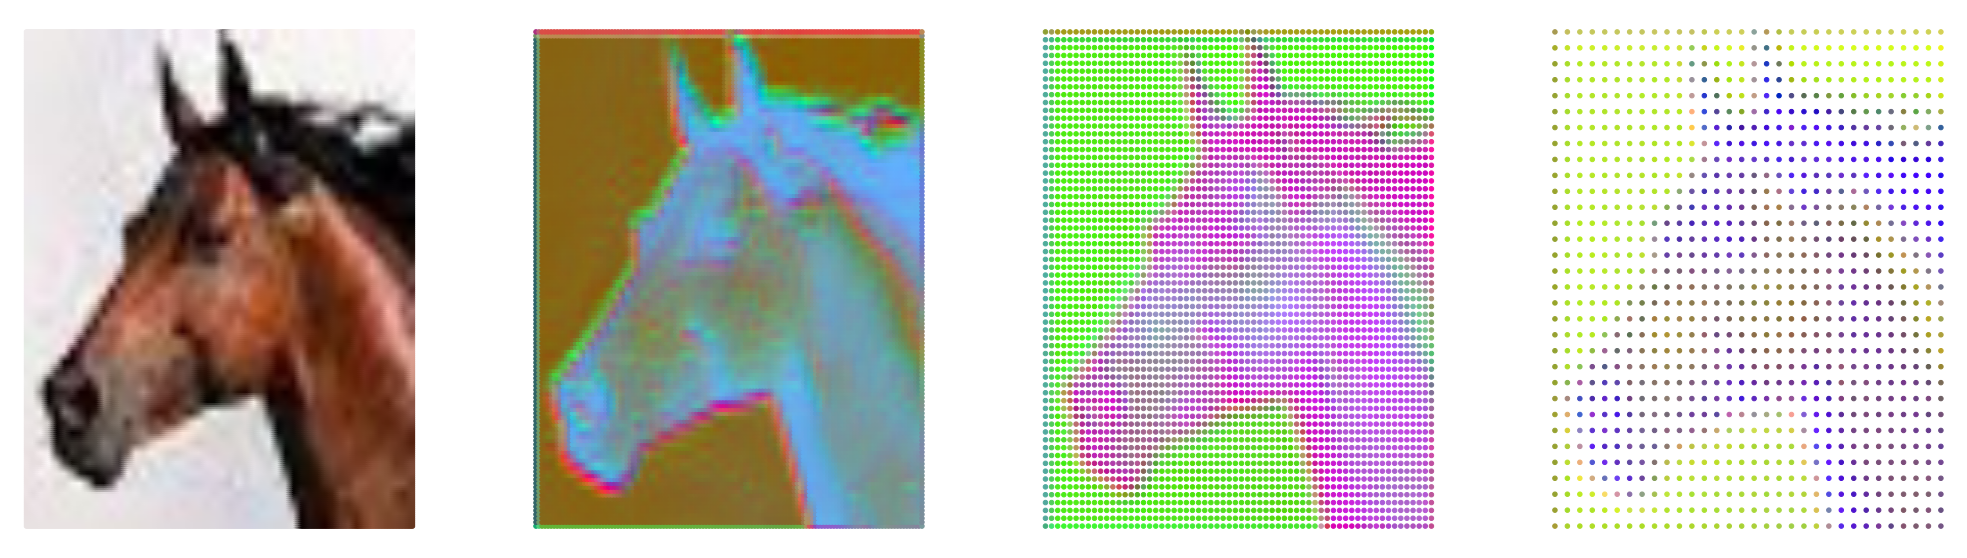

In [7]:
T = imagAnimal_Train[4]
conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
TC1 = conv1(T)
TC2 = conv2(TC1)
TC3 = conv3(TC2)
lstX_1, lstY_1, lstRGB_1 = getTensorImag(T, [0,1,2])
lstX_2, lstY_2, lstRGB_2 = getTensorImag(TC1, [0,1,2])
lstX_3, lstY_3, lstRGB_3 = getTensorImag(TC2, [0,1,2])
lstX_4, lstY_4, lstRGB_4 = getTensorImag(TC3, [0,1,2])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(35,10))
ax1.axis('off');ax2.axis('off');ax3.axis('off');ax4.axis('off')
ax1.scatter(lstX_1,lstY_1, c=lstRGB_1, s=20)
ax2.scatter(lstX_2,lstY_2, c=lstRGB_2, s=20)
ax3.scatter(lstX_3,lstY_3, c=lstRGB_3, s=20)
ax4.scatter(lstX_4,lstY_4, c=lstRGB_4, s=20)
fig.show()

---
## Definir la Red [Arquitectura](http://pytorch.org/docs/stable/nn.html)

Aquí, se definirá una arquitectura CNN. En lugar de un Perceptrón Multicapa, que usó capas lineales y completamente conectadas, se usará lo siguiente:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), que se puede considerar como una pila de imágenes filtradas.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), que reducen el tamaño x-y de una entrada, manteniendo solo los píxeles más _activos_ de la capa anterior.
* Las capas habituales Linear + Dropout para evitar sobreajuste y producir una salida de dimensión 10.

El resultado es una red con 2 capas convolucionales que se muestra en la imagen a continuación y en el código, y se le ha dado un código de inicio con una capa convolucional y una capa máxima.

<img src="images/two_layer_conv.png" width="500px">


### Definir un modelo con múltiples capas convolucionales y definir el comportamiento de la red de avance.

Cuantas más capas convolucionales se incluyan, más patrones complejos de color y forma podrá detectar un modelo. Se sugiere que el modelo final incluya 2 o 3 capas convolucionales, así como capas lineales + dropout en el medio para evitar el sobreajuste.

Es una buena práctica observar las investigaciones e implementaciones existentes de modelos relacionados como punto de partida para definir sus propios modelos. Puede resultarle útil mirar [este ejemplo de clasificación de PyTorch](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) o [este, un ejemplo más complejo de Keras](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) para ayudar a decidir la estructura final.

#### Volumen de salida para una capa convolucional

Para calcular el tamaño de salida de una capa convolucional dada, podemos realizar el siguiente cálculo (tomado del [curso cs231n de Stanford] (http://cs231n.github.io/convolutional-networks/#layers)):
> Podemos calcular el tamaño espacial del volumen de salida en función del tamaño del volumen de entrada (W), el tamaño del núcleo / filtro (F), la zancada con la que se aplican (S) y la cantidad de relleno de ceros utilizado (P) en la frontera. La fórmula correcta para calcular cuántas neuronas definen el output_W viene dada por `(W − F + 2P) / S + 1`.

Por ejemplo, para una entrada de 7x7 y un filtro de 3x3 con stride 1 y pad 0 obtendríamos una salida de 5x5. Con la zancada 2 obtendríamos una salida de 3x3.

In [8]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

## move tensors to GPU if CUDA is available
#if torch.cuda.is_available():
#    model.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Especificar la [Función de pérdida] (http://pytorch.org/docs/stable/nn.html#loss-functions) y el [Optimizador] (http://pytorch.org/docs/stable/optim.html)

Decidir qué función de optimización y pérdida es la más adecuada para esta tarea de clasificación. Los ejemplos de códigos vinculados de arriba pueden ser un buen punto de partida; [este ejemplo de clasificación de PyTorch] (https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) o [este, un ejemplo más complejo de Keras] (https://github.com/keras -equipo / keras / blob / master / examples / cifar10_cnn.py). Prestar mucha atención al valor de ** tasa de aprendizaje **, ya que este valor determina cómo el modelo converge a un pequeño error.



In [9]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Entrenamiento de la red

Hay que observar como la pérdida en entrenamiento y validación disminuye con el tiempo; si la pérdida de validación aumenta alguna vez, indica un posible sobreajuste. 

In [10]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    ##for data, target in train_loader:
    for K in range(targetAnimal_Train.size(0)):
        imagAnimal = imagAnimal_Train[K]
        targetAnimal = targetAnimal_Train[K]
        
        ## move tensors to GPU if CUDA is available
        #if torch.cuda.is_available():
        #    imagAnimal, targetAnimal = imagAnimal.cuda(), targetAnimal.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(imagAnimal)
        # calculate the batch loss
        loss = criterion(output, targetAnimal)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*targetAnimal_Train.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    #for data, target in valid_loader:
    for K in range(targetAnimal_Test.size(0)):
        imagAnimal = imagAnimal_Test[K]
        targetAnimal = targetAnimal_Test[K]
        
        ## move tensors to GPU if CUDA is available
        #if torch.cuda.is_available():
        #    imagAnimal, targetAnimal = imagAnimal.cuda(), targetAnimal.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(imagAnimal)
        # calculate the batch loss
        loss = criterion(output, targetAnimal)
        # update average validation loss 
        valid_loss += loss.item()*targetAnimal_Test.size(0)
    
    # calculate average losses
    train_loss = train_loss/targetAnimal_Train.size(0)
    valid_loss = valid_loss/targetAnimal_Test.size(0)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'data/model_animals.pt')
        valid_loss_min = valid_loss
torch.save(model.state_dict(), 'data/model_end.pt')

Epoch: 1 	Training Loss: 83.249133 	Validation Loss: 28.277380
Validation loss decreased (inf --> 28.277380).  Saving model ...
Epoch: 2 	Training Loss: 40.475085 	Validation Loss: 10.420669
Validation loss decreased (28.277380 --> 10.420669).  Saving model ...
Epoch: 3 	Training Loss: 23.551403 	Validation Loss: 9.825063
Validation loss decreased (10.420669 --> 9.825063).  Saving model ...
Epoch: 4 	Training Loss: 22.792697 	Validation Loss: 9.725365
Validation loss decreased (9.825063 --> 9.725365).  Saving model ...
Epoch: 5 	Training Loss: 21.338174 	Validation Loss: 9.708276
Validation loss decreased (9.725365 --> 9.708276).  Saving model ...
Epoch: 6 	Training Loss: 21.947178 	Validation Loss: 9.578059
Validation loss decreased (9.708276 --> 9.578059).  Saving model ...
Epoch: 7 	Training Loss: 20.668264 	Validation Loss: 9.548942
Validation loss decreased (9.578059 --> 9.548942).  Saving model ...
Epoch: 8 	Training Loss: 20.954787 	Validation Loss: 9.271080
Validation loss decr

In [11]:
print(imagAnimal_Test[5].shape, targetAnimal_Test[5])

torch.Size([1, 3, 256, 256]) tensor([0, 1, 0, 0])


In [12]:
modelOk = Net()
modelOk.load_state_dict(torch.load('data/model_end.pt'))
modelOk.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## Ahora chequeamos algún elemento del conjunto de validación

In [40]:
# Oks = 3;5;12;14
Itest = 14
#Out_Test = modelOk.forward(imagAnimal_Train[Itest])
Out_Test = modelOk(imagAnimal_Test[Itest])
pred = Out_Test.max(1, keepdim=True)
print("pred=", pred)
#print("Predict", torch.max(Out_Test,1))
#print(Out_Test)
#print(torch.nn.functional.softmax(Out_Test[0], dim=0))
print(targetAnimal_Test[Itest])
print(Out_Test)

pred= torch.return_types.max(
values=tensor([[14.6159],
        [11.0146],
        [15.1854],
        [13.0013]], grad_fn=<MaxBackward0>),
indices=tensor([[0],
        [0],
        [0],
        [1]]))
tensor([0, 0, 0, 1])
tensor([[14.6159,  5.0284, -2.2629, -2.0340, -2.6381, -2.2767, -2.9729, -2.5208,
         -2.2578, -2.2566],
        [11.0146,  4.4685, -1.0004, -1.4864, -2.1785, -2.1552, -2.2881, -1.9823,
         -2.0022, -1.6765],
        [15.1854,  0.9751, -1.2437, -1.3545, -2.3629, -1.4418, -2.0212, -2.0352,
         -2.3678, -2.1098],
        [-0.0858, 13.0013, -1.8249, -1.5437, -2.3656, -1.1364, -2.0393, -1.5089,
         -1.8473, -1.7057]], grad_fn=<AddmmBackward0>)


C:\Users\valer_z\AppData\Local\Temp/ipykernel_9180/2983415004.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


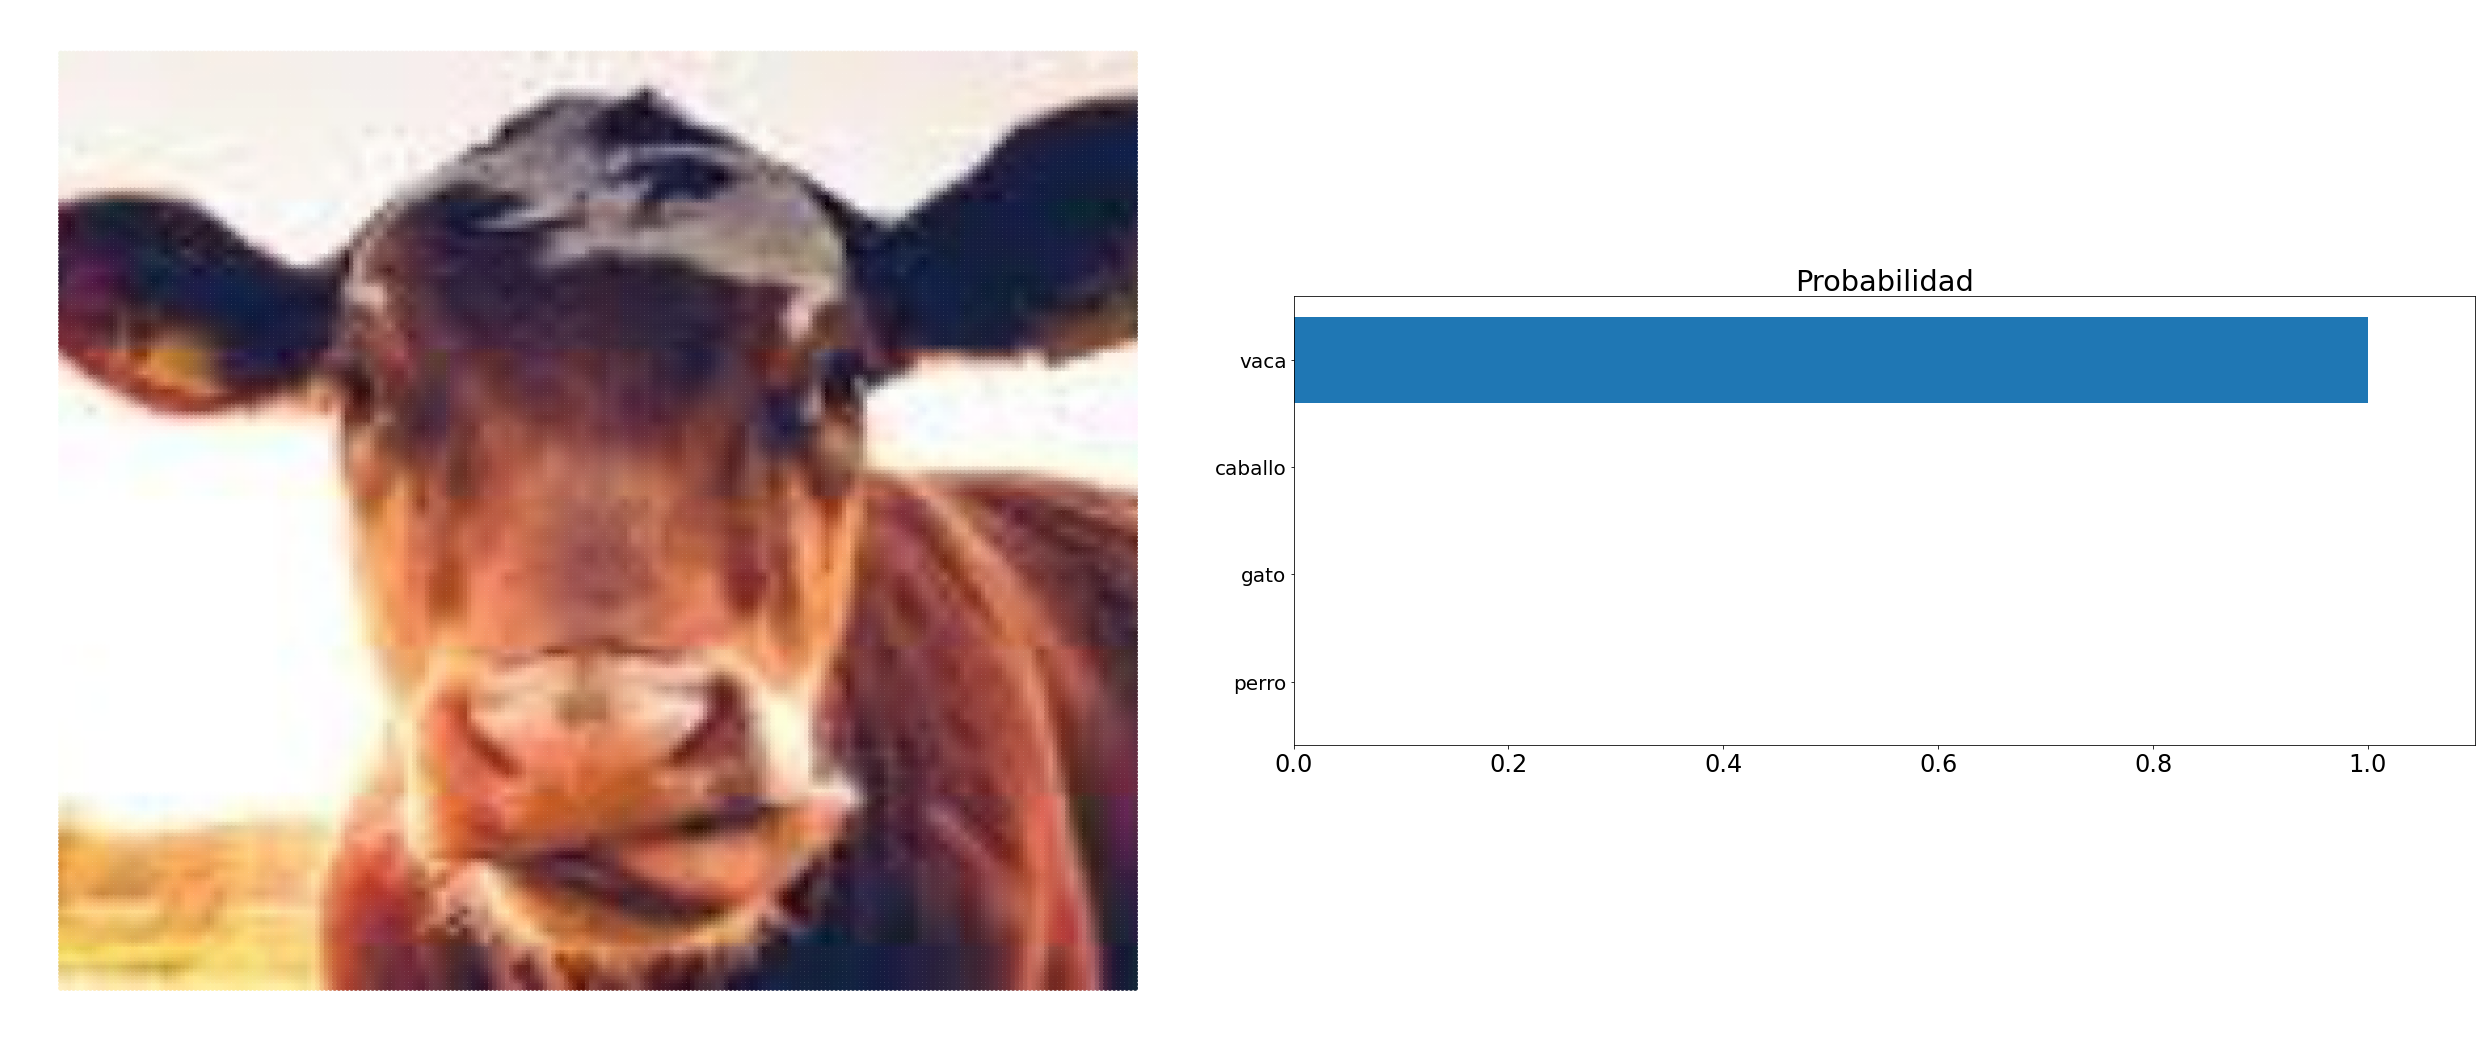

In [41]:
T = imagAnimal_Test[Itest]
lstX, lstY, lstRGB = getTensorImag(T, [0,1,2])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35,15))
plt.rc('font', size=24)  
ax1.scatter(lstX,lstY, c=lstRGB, s=20)
ax1.axis('off')
ax2.barh(np.arange(4), pred[1])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(4))
ax2.set_yticklabels(['perro','gato','caballo','vaca'], size='small');
ax2.set_title('Probabilidad')
ax2.set_xlim(0, 1.1)
fig.show()
plt.tight_layout()